### PART-1

In [32]:
from datasets import load_dataset
import random

# 1. Load the full arXiv summarization dataset
raw = load_dataset("ccdv/arxiv-summarization", split="train")

# 2. Subsample 5,000 examples (shuffle first for randomness)
raw = raw.shuffle(seed=42).select(range(5000))


In [33]:
# The dataset has fields 'article' and 'abstract'
inputs  = raw["article"]
targets = raw["abstract"]

In [34]:
from transformers import AutoTokenizer

# Replace with your TinyLlama tokenizer checkpoint
tokenizer = AutoTokenizer.from_pretrained("TinyLlama/TinyLlama_v1.1")
tokenizer.pad_token = tokenizer.eos_token
def preprocess_causal(batch):
    inputs = []
    for article, summary in zip(batch["article"], batch["abstract"]):
        # concat with EOS tokens
        text = article + tokenizer.eos_token + summary + tokenizer.eos_token
        ids  = tokenizer(text, truncation=True, max_length=1024)["input_ids"]
        inputs.append(ids)
    # pad to max length and create labels = input_ids
    batch_out = tokenizer.pad(
        {"input_ids": inputs},
        padding="max_length",
        max_length=1024,
        return_tensors="pt",
    )
    batch_out["labels"] = batch_out["input_ids"].clone()
    return batch_out

tokenized = raw.map(
    preprocess_causal,
    batched=True,
    remove_columns=raw.column_names,
)

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [35]:
split = tokenized.train_test_split(test_size=0.20, seed=42)
test_valid = split["test"].train_test_split(test_size=0.50, seed=42)

datasets = {
    "train": split["train"],
    "validation": test_valid["train"],
    "test": test_valid["test"],
}

print({k: len(v) for k, v in datasets.items()})
# -> {'train': 4000, 'validation': 500, 'test': 500}


{'train': 4000, 'validation': 500, 'test': 500}


### PART-2

In [2]:
# Install dependencies if needed
# pip install datasets transformers

from datasets import load_dataset
from transformers import PegasusTokenizer

# 1. Load & subsample 5 000 examples
raw = load_dataset("ccdv/arxiv-summarization", split="train")
raw = raw.shuffle(seed=42).select(range(5000))

# 2. Load Pegasus‐XSum tokenizer and set special tokens
tokenizer = PegasusTokenizer.from_pretrained("google/pegasus-xsum")
# By default PegasusTokenizer.pad_token == '<pad>' and eos_token == '</s>'
# If you want to pad with eos instead of a separate pad symbol:
tokenizer.pad_token = tokenizer.eos_token
tokenizer.pad_token_id = tokenizer.eos_token_id

# 3. Define max lengths
max_input_length  = 512   # Pegasus‐XSum max supported input
max_target_length = 256

# 4. Tokenization function
def tokenize_fn(batch):
    # Encode articles
    enc = tokenizer(
        batch["article"],
        truncation=True,
        padding="max_length",
        max_length=max_input_length,
    )
    # Encode abstracts as labels
    dec = tokenizer(
        batch["abstract"],
        truncation=True,
        padding="max_length",
        max_length=max_target_length,
    )
    return {
        "input_ids": enc["input_ids"],
        "attention_mask": enc["attention_mask"],
        "labels": dec["input_ids"],
    }

# 5. Apply tokenization and remove original columns
tokenized = raw.map(
    tokenize_fn,
    batched=True,
    remove_columns=raw.column_names,
)

# 6. Split into Train/Validation/Test (80/10/10)
split_1 = tokenized.train_test_split(test_size=0.20, seed=42)
split_2 = split_1["test"].train_test_split(test_size=0.50, seed=42)

datasets = {
    "train": split_1["train"],         # 4 000 samples
    "validation": split_2["train"],    #   500 samples
    "test": split_2["test"],           #   500 samples
}

print({k: len(v) for k, v in datasets.items()})
# -> {'train': 4000, 'validation': 500, 'test': 500}


{'train': 4000, 'validation': 500, 'test': 500}


### PART-3

In [2]:
from transformers import (
    AutoTokenizer, AutoModelForSeq2SeqLM,
    Seq2SeqTrainer, Seq2SeqTrainingArguments,
    DataCollatorForSeq2Seq
)
from peft import get_peft_model, LoraConfig, TaskType

# Load
tokenizer = AutoTokenizer.from_pretrained("google/pegasus-xsum")
model = AutoModelForSeq2SeqLM.from_pretrained("google/pegasus-xsum", device_map="auto")

# LoRA
peft_config = LoraConfig(task_type=TaskType.SEQ_2_SEQ_LM, r=8, lora_alpha=16,
                         lora_dropout=0.1, target_modules=["q_proj","v_proj"])
model = get_peft_model(model, peft_config)

# Collator
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, label_pad_token_id=-100)

# Args
training_args = Seq2SeqTrainingArguments(
    output_dir="./lora-pegasus-xsum",
    per_device_train_batch_size=4, per_device_eval_batch_size=4,
    gradient_accumulation_steps=2,
    eval_strategy="epoch", save_strategy="epoch",
    num_train_epochs=4,
    fp16=False,            # ← disable half-precision
    bf16=False,            # ← or try bf16 if supported
    learning_rate=3e-5,    # smaller LR also helps stability
    max_grad_norm=1.0,     # gradient clipping
    warmup_steps=500,
    predict_with_generate=True,
    generation_max_length=256,
    generation_num_beams=4,
)
# Trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=datasets["train"],
    eval_dataset=datasets["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)
trainer.train()


trainer.save_model("./lora-pegasus-xsum")


2025-05-15 15:34:57.762753: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-15 15:34:57.770256: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747337697.779148 1077159 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747337697.781757 1077159 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747337697.788763 1077159 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Epoch,Training Loss,Validation Loss
1,3.579700,2.768593
2,2.933300,2.575604
3,2.777700,2.544457
4,2.742800,2.536259


In [3]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from peft import PeftModel

# 1. Reload & split raw test set (to restore article/abstract)
raw = (
    load_dataset("ccdv/arxiv-summarization", split="train")
    .shuffle(seed=42)
    .select(range(5000))
)
split1 = raw.train_test_split(test_size=0.20, seed=42)
split2 = split1["test"].train_test_split(test_size=0.50, seed=42)
raw_test = split2["test"]  # has 'article' & 'abstract'

# 2. Reattach text columns to your tokenized-only test split
#    (assumes `datasets["test"]` exists from your earlier tokenization)
tokenized_test = (
    datasets["test"]
    .add_column("article", raw_test["article"])
    .add_column("abstract", raw_test["abstract"])
)

# 3. Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("google/pegasus-xsum")

# 4. Load two separate model instances:
#    A. Base Pegasus
base_model = AutoModelForSeq2SeqLM.from_pretrained(
    "google/pegasus-xsum", device_map="auto"
)
#    B. Fine-tuned (wraps a fresh base internally)
ft_base_model = AutoModelForSeq2SeqLM.from_pretrained(
    "google/pegasus-xsum", device_map="auto"
)
finetuned_model = PeftModel.from_pretrained(
    ft_base_model, "./lora-pegasus-xsum", device_map="auto"
)

# 5. Summarization helper
def generate_summaries(model, articles):
    model.eval()
    outs = []
    for art in articles:
        inputs = tokenizer(
            art,
            truncation=True,
            padding="longest",
            max_length=512,
            return_tensors="pt"
        ).to(model.device)
        sum_ids = model.generate(
            **inputs,
            max_length=256,
            num_beams=4,
            early_stopping=True
        )
        outs.append(tokenizer.decode(sum_ids[0], skip_special_tokens=True))
    return outs

# 6. Select 10 samples and run inference
articles      = tokenized_test["article"][:10]
ground_truths = tokenized_test["abstract"][:10]

base_summaries      = generate_summaries(base_model,      articles)
finetuned_summaries = generate_summaries(finetuned_model, articles)


Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-xsum and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-xsum and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
for i in range(3):
    print("ARTICLE:", articles[i][:200], "…")
    print("BASE:     ", base_summaries[i])
    print("FINE-TUNED:", finetuned_summaries[i])
    print("-" * 80)


ARTICLE: the performance guarantee of local search and greedy algorithms for scheduling problems is well studied and understood . for most algorithms , matching upper and lower bounds on their approximation ra …
BASE:      We study the robustness of local search and greedy algorithms for scheduling problems .
FINE-TUNED: we study the performance guarantee of local search and greedy algorithms for scheduling problems in the framework of smoothed analysis , in which instances are subject to some degree of random noise . since pure nash equilibria can be seen as local optima , our results also imply a new bound on the smoothed price of anarchy , showing that known worst - case results are too pessimistic in the presence of noise . since pure nash equilibria can be seen as local optima , our results also imply a new bound on the smoothed price of anarchy , showing that known worst - case results are too pessimistic in the presence of noise .
------------------------------------------------

### PART-4

### PART-B

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


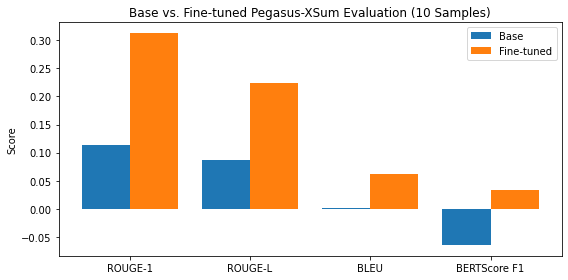

In [37]:
# === Part 4: Evaluation ===

import evaluate
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load metrics
rouge_metric     = evaluate.load("rouge")
bertscore_metric = evaluate.load("bertscore")
cc = SmoothingFunction().method4

# 2. Compute all four metrics for a given set of summaries
def compute_all_metrics(hyps, refs):
    # ROUGE
    rouge_res = rouge_metric.compute(
        predictions=hyps, references=refs, use_stemmer=True
    )
    avg_rouge1 = float(rouge_res["rouge1"])
    avg_rougeL = float(rouge_res["rougeL"])

    # BLEU via NLTK
    bleu_scores = [
        sentence_bleu([r.split()], h.split(), smoothing_function=cc)
        for h, r in zip(hyps, refs)
    ]
    avg_bleu = sum(bleu_scores) / len(bleu_scores)

    # BERTScore F1
    bert_res = bertscore_metric.compute(
        predictions=hyps,
        references=refs,
        lang="en",
        rescale_with_baseline=True
    )
    avg_bertscore = sum(bert_res["f1"]) / len(bert_res["f1"])

    return {
        "ROUGE-1":      avg_rouge1,
        "ROUGE-L":      avg_rougeL,
        "BLEU":         avg_bleu,
        "BERTScore F1": avg_bertscore,
    }

# 3. Score both models
base_scores = compute_all_metrics(base_summaries,      ground_truths)
ft_scores   = compute_all_metrics(finetuned_summaries, ground_truths)

# 4. Build DataFrame for plotting
df = pd.DataFrame({
    "Metric":       list(base_scores.keys()),
    "Base":         list(base_scores.values()),
    "Fine-tuned":   list(ft_scores.values()),
})

# 5. Plot side-by-side grouped bar chart
x = range(len(df))
plt.figure(figsize=(8, 4))
plt.bar([i - 0.2 for i in x], df["Base"],       width=0.4, label="Base")
plt.bar([i + 0.2 for i in x], df["Fine-tuned"], width=0.4, label="Fine-tuned")
plt.xticks(x, df["Metric"])
plt.ylabel("Score")
plt.title("Base vs. Fine-tuned Pegasus-XSum Evaluation (10 Samples)")
plt.legend()
plt.tight_layout()
plt.show()
